# Exploring r/NBA Comments Using NLP Techniques

## Imports

In [1]:
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
import string
from tqdm import tqdm
import re
import warnings
from plotnine import *

warnings.filterwarnings('ignore')
tqdm.pandas()
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Analyzing the Comments

In [3]:
# loading the data frame
ind_comments = pd.read_csv('nba_reddit_threads_by_comment.csv')

# remove the new line and \r characters
ind_comments['thread_comments'] = ind_comments['thread_comments'].progress_apply(lambda x: x.replace('\n', ' '))
ind_comments['thread_comments'] = ind_comments['thread_comments'].progress_apply(lambda x: x.replace('\r', ' '))

# stopwords to remove from the text to tokenize
punctuation = string.punctuation + ' ' + ' '.join(stopwords)

# loading the scpacy tokenized
NLP = spacy.load('en_core_web_sm')

# tokenizing the comments
ind_comments['comment_tokens'] = ind_comments['thread_comments'].progress_apply(lambda x: [x.lemma_.lower() for x in NLP(x) if x.lemma_.lower() not in punctuation])

100%|██████████| 10000/10000 [02:27<00:00, 67.67it/s]


In [4]:
# expanding tokens 
token_data = (ind_comments
              .explode('comment_tokens')
             )

# calculating the count frequency of each token
token_frequency = (token_data
                  .groupby(by=['comment_tokens'])
                  .agg({'comment_tokens': 'count'})
                  .rename(columns={'comment_tokens': 'token_frequency'})
                  .reset_index()
                 ).sort_values(['token_frequency'], ascending = False)

# the tokens ended up not being super useful for my analysis, but they are included in case a user finds a use for them

## Loading Transformers and Sentiment

### Named Entity Analysis

In [ ]:
# code to generate the named entities for each comment, takes a long time to run so ouput is not shown here

from transformers import pipeline

# selecting the named entities model
ner = pipeline('ner', grouped_entities=True)

# using the model on each comment and saving it to the data frame
ind_comments['named_entities'] = ind_comments['thread_comments'].progress_apply(lambda x: [i['word'] for i in ner(x)])


### Sentiment Analysis

In [ ]:
#generate the sentiments for each comment

# loading in the comments data frame if it has not been loaded
# ind_comments = pd.read_csv('ind_comments.csv')

# selecting the sentiment model
sentiment_classifier = pipeline('sentiment-analysis')

# list to store the sentiments
sentiments = []

# going through each comment in the data frame and passing it into the model, saving the sentiment label
for i in range(len(ind_comments)):
    try:
        sentiment = sentiment_classifier(ind_comments['thread_comments'][i])[0]['label']
        sentiments.append(sentiment)
    except:
        sentiments.append(' ')
        continue

# saving the sentiments in the data frame     
ind_comments['sentiments'] = sentiments

# Saving the results to a CSV for later anlaysis
#ind_comments.to_csv('ind_comments.csv', index = False)

## Functions for Analysis

In [120]:
# Here are a variety of functions used for the later analysis

def LoadCommentSentimentFiles(explode = True):
    '''
    This function loads the CSV file from the Named Entity and Sentiment analysis before. It fixes the issue of the csv file saving a list as a string.
    
    input:
    explode: If true, the returned data frame has a named entity for each row. If not, then each comment represents one row.

    returns: 
    entities: independent comments data frame with proper data types. Each row represents a named entity for a given comment.
    ind_comments: a data frame with each row representing one comment
    '''
    
    # read in the generated csv 
    ind_comments = pd.read_csv('ind_comments.csv')
    
    # remove the brackets and split the words by the commas
    ind_comments['named_entities'] = ind_comments['named_entities'].apply(lambda x: x.strip("[]").split(','))
    
    # explode the list to be an entity per row when explode = True
    if explode == True:
      entities = ind_comments.explode('named_entities')
    
      # remove quotations and spaces
      entities['named_entities'] = entities['named_entities'].apply(lambda x: x.replace("'", '').replace(' ', ''))

      return entities
    
    else:
      return ind_comments

def LoadTitleSentimentFile():
    '''
    A function that just loads in the saved "titles_named_entities.csv" file
    '''
    entities = pd.read_csv('titles_named_entities.csv')
    return entities

def CombineEntitesAndSentiments(entities, positive = False, cutoff = 25, return_sentiment_and_frequency_df = False):
    '''
    A function to order the sentiments based on most positive or negative. 
    
    Input:
    entites: The dataframe with the named entities and their sentiments
    positive: If False, the function will make Negative = 1 and Positive = 0. This means that the data frame will be sorted as most negative to least negative. If positive = True, it will be the opposite.
    cutoff: The value of how many comments a named entity must appear in.
    return_frequency_df: If True, the function returns the entity_combined, token_frequency, and sentiment_frequency data frame.
    
    Output:
    entity_combined: A data frame in descending order of either postive or negative fraction depending on the 'positive' input.
    entity_frequency: A data frame that shows the frequency count of each named entity
    entity_sentiments: A data frame that counts up the total sentiment of a named entity based on the 'positive' input.
    '''

    # generate the transformation mapping based on if the user wants the most negative or most positive
    if positive == False:
      # summing so want most negative entities to have the largest value
      transformation = {'POSITIVE': 0, 'NEGATIVE': 1} 
    else:
      # summing so want most positive entities to have the largest value
      transformation = {'POSITIVE': 1, 'NEGATIVE': 0}

    # map to the transformation 
    entities['sentiments'] = entities['sentiments'].map(transformation)
    
    # calculate the sum of the sentiments for each sentiment
    entity_sentiments = (entities
                     .groupby(by = ['named_entities'])
                     .sum(['sentiments'])
                     .reset_index()
                     .sort_values(['sentiments'], ascending = False))
    
    # calculate the count frequency for each entity
    entity_frequency = (entities
                      .groupby(by=['named_entities'])
                      .agg({'named_entities': 'count'})
                      .rename(columns={'named_entities': 'entity_frequency'})
                      .reset_index()
                     ).sort_values(['entity_frequency'], ascending = False)

    # merge the sentiments and frequency data frames
    combined_entities = entity_sentiments.merge(entity_frequency, on = 'named_entities', how = 'left')

    # fraction is the proportion of the entity's appearances are the selected sentiment. 
    # This can be better than raw counts to show lesser talked about entities 
    combined_entities['fraction'] = (combined_entities['sentiments'] / combined_entities['entity_frequency']) * 100

    #select a cutoff for how many times that entity must of show up
    idx = combined_entities['entity_frequency'] >= cutoff

    #sort the dataframe so that the largest fraction is at the top
    combined_entities = combined_entities[idx].sort_values('fraction', ascending = False)

    
    if return_sentiment_and_frequency_df == False:
      return combined_entities
    else:
      return combined_entities, entity_frequency, entity_sentiments

## Graphing The Findings

### The Most Frequent Named Entities From The Comments


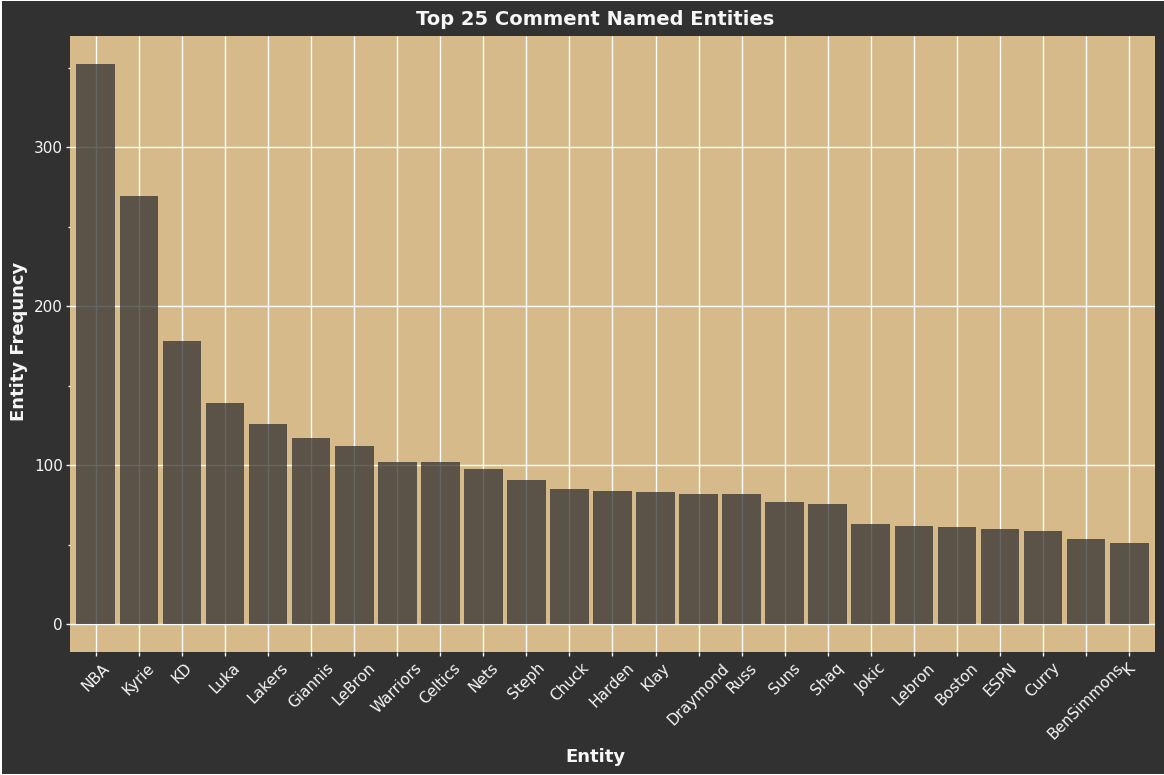

<ggplot: (8741681330029)>

In [121]:
# Load In The Data
entities = LoadCommentSentimentFiles()
combined_entities, entity_frequency, entity_sentiments = CombineEntitesAndSentiments(entities, return_sentiment_and_frequency_df = True)

# List to order the data in the graph
named_entity_list = entity_frequency['named_entities'][1:26].to_list()

p = (ggplot(entity_frequency[1:26], aes(x = 'named_entities', y = 'entity_frequency')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Entity', y = 'Entity Frequncy', title = 'Top 25 Comment Named Entities') + 
     theme(axis_text_x = (element_text(angle = 45)), plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8)) +
     scale_x_discrete(limits = named_entity_list)
     )
# display the graph
p

### The Count of Postive & Negative Comments

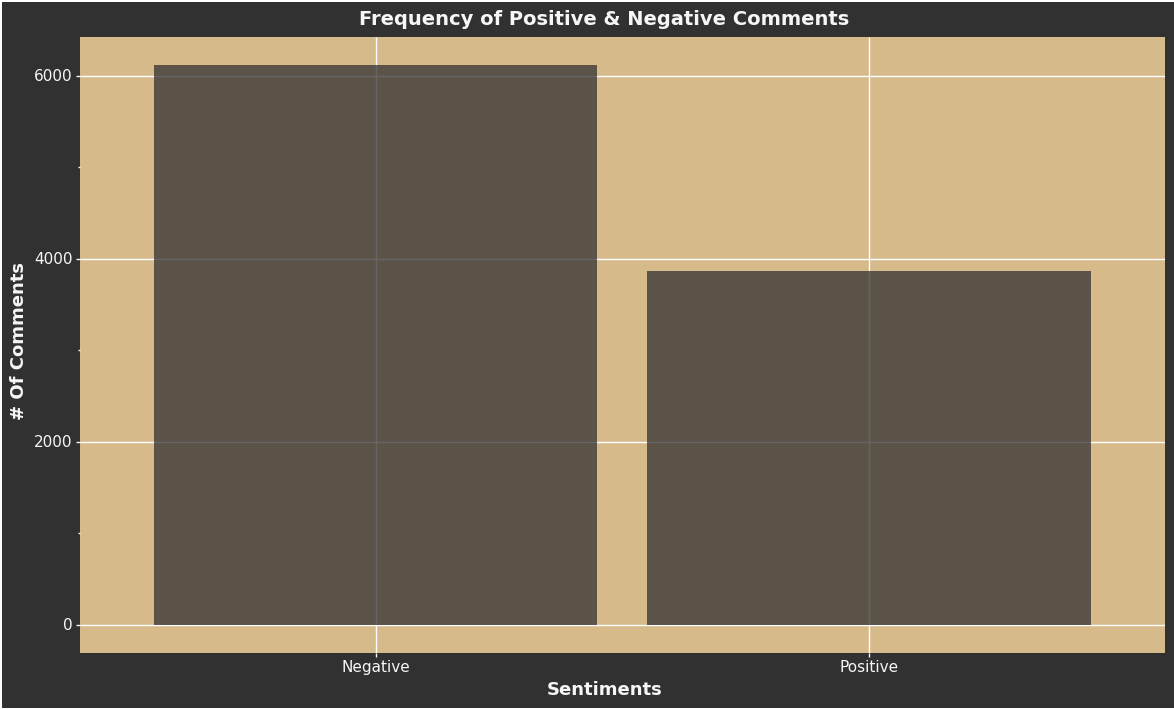

<ggplot: (8741681038051)>

In [122]:
# Can do a generic graph for sentiment, postive vs negative

ind_comments = LoadCommentSentimentFiles(False)

# calculate the frequency of the sentiment values
sentiment_frequency = (ind_comments
                  .groupby(by=['sentiments'])
                  .agg({'sentiments': 'count'})
                  .rename(columns={'sentiments': 'sentiment_frequency'})
                  .reset_index()
                 ).sort_values(['sentiment_frequency'], ascending = False)

# make the labels of sentiments a normal case
sentiment_frequency['sentiments'][1] = 'Negative'
sentiment_frequency['sentiments'][2] = 'Positive'

p = (ggplot(sentiment_frequency[:2], aes(x = 'sentiments', y = 'sentiment_frequency')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Sentiments', y = '# Of Comments', title = 'Frequency of Positive & Negative Comments') + 
     theme(plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8))
     )
p

## Graphing Negative Comments

### The Named Entities with the Most Negative Comments

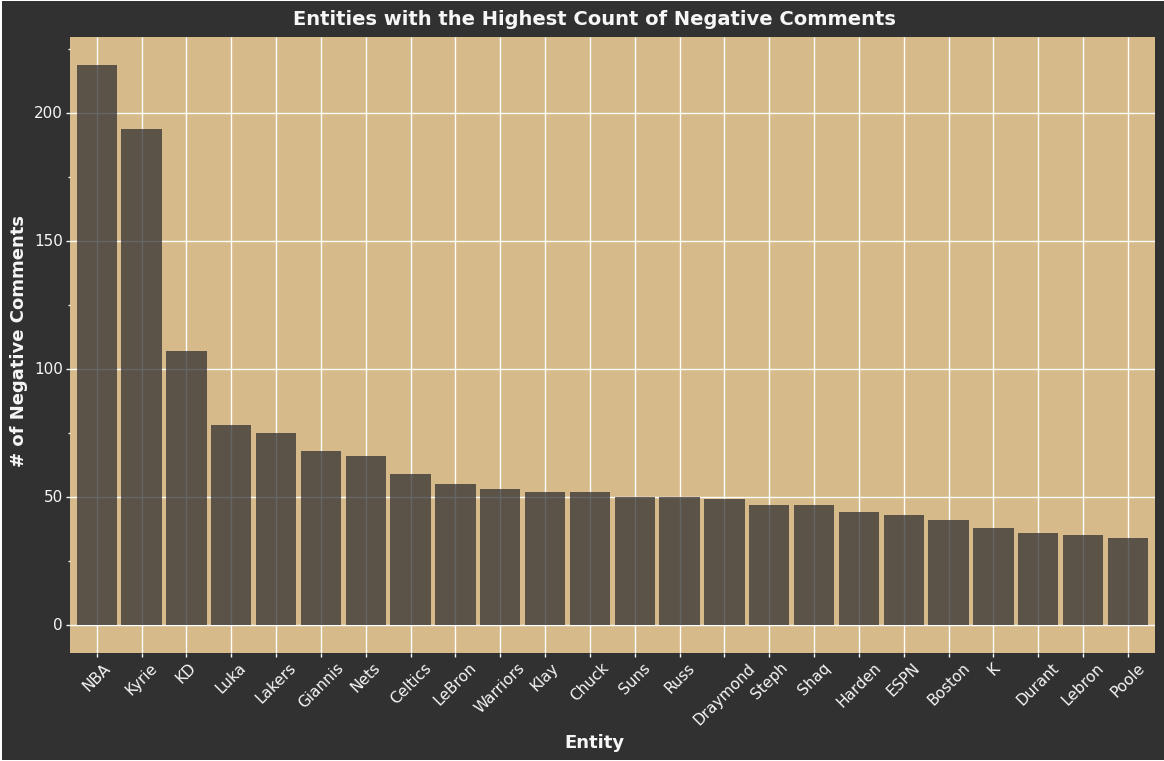

<ggplot: (8741688739612)>

In [123]:
# load the data
entities = LoadCommentSentimentFiles()
combined_entities = CombineEntitesAndSentiments(entities)

# sort by sentiments instead of the fraction
combined_entities = combined_entities.sort_values('sentiments', ascending = False)

# list to order the data points in the graph
named_entity_list = combined_entities['named_entities'][1:25].to_list()

# remove the first data point beacuse it is blank
p = (ggplot(combined_entities[1:25], aes(x = 'named_entities', y = 'sentiments')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Entity', y = '# of Negative Comments', title = 'Entities with the Highest Count of Negative Comments') + 
     theme(axis_text_x = (element_text(angle = 45)), plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8)) +
     scale_x_discrete(limits = named_entity_list)
     )
p

### The Named Entities with the Highest Proportion of Negative Comments

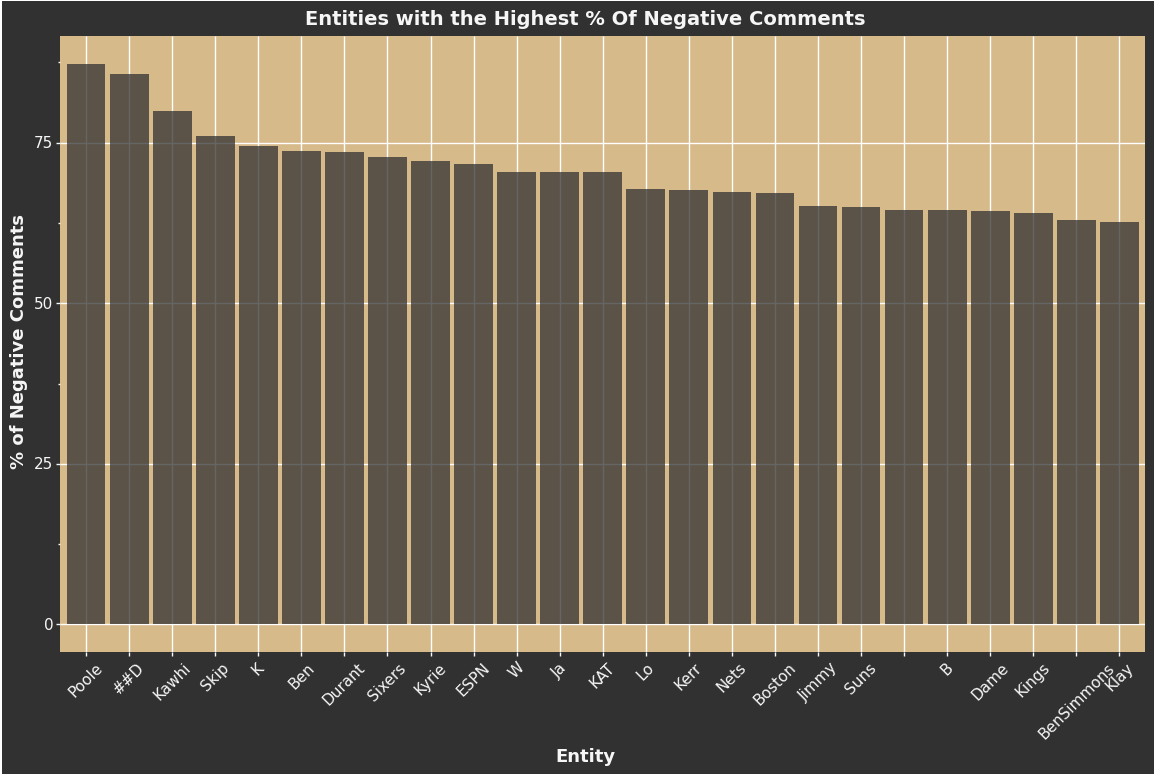

<ggplot: (8741681207873)>

In [126]:
# load the data
entities = LoadCommentSentimentFiles()
combined_entities = CombineEntitesAndSentiments(entities)

# select to order the findings
named_entity_list = combined_entities['named_entities'][:25].to_list()

#create the graph
p = (ggplot(combined_entities[:25], aes(x = 'named_entities', y = 'fraction')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Entity', y = '% of Negative Comments', title = 'Entities with the Highest % Of Negative Comments') + 
     theme(axis_text_x = (element_text(angle = 45)), plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8)) +
     scale_x_discrete(limits = named_entity_list)
     )
p

## Graphing Positive Comments

### The Named Entities with the Highest Number of Positive Comments

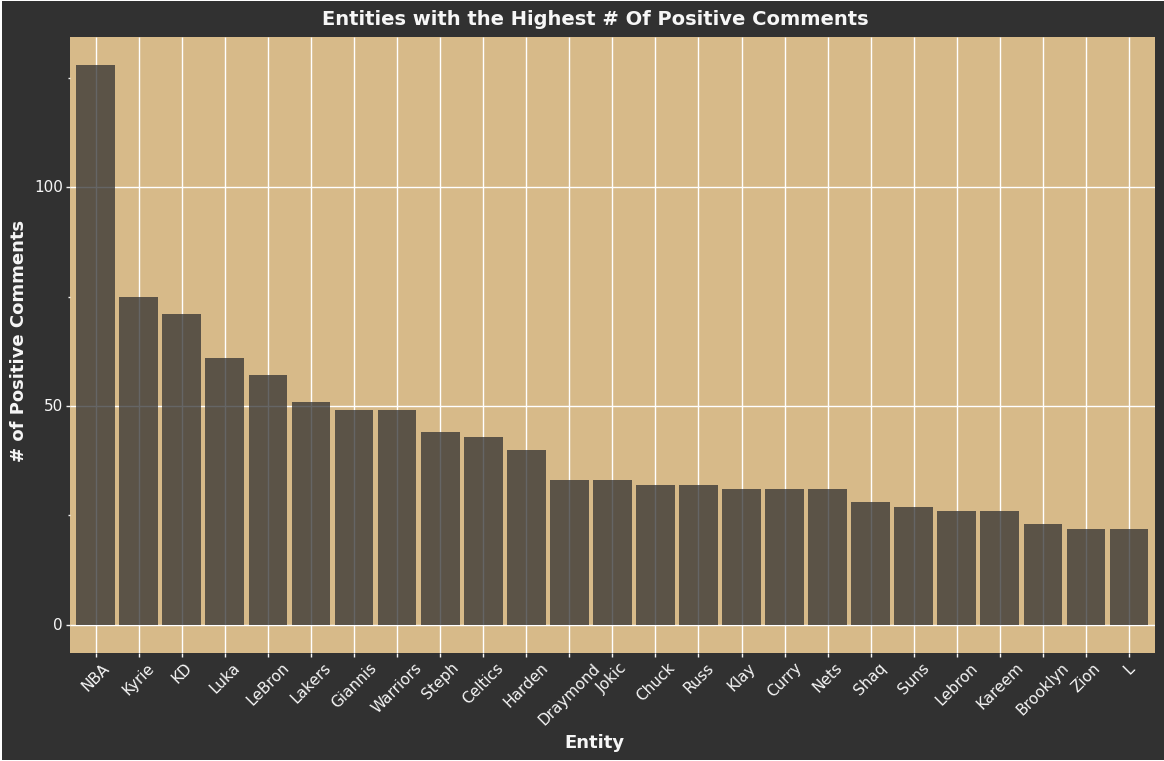

<ggplot: (8741689523143)>

In [127]:
# load the data
entities = LoadCommentSentimentFiles()
combined_entities = CombineEntitesAndSentiments(entities, positive = True)

# sorting by sentiment count instead of fraction
combined_entities = combined_entities.sort_values('sentiments', ascending = False)

# selecting for the order
named_entity_list = combined_entities['named_entities'][1:26].to_list()

p = (ggplot(combined_entities[1:26], aes(x = 'named_entities', y = 'sentiments')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Entity', y = '# of Positive Comments', title = 'Entities with the Highest # Of Positive Comments') + 
     theme(axis_text_x = (element_text(angle = 45)), plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8)) +
     scale_x_discrete(limits = named_entity_list)
     )
p

### The Named Entities with the Highest Percentage of Positive Comments

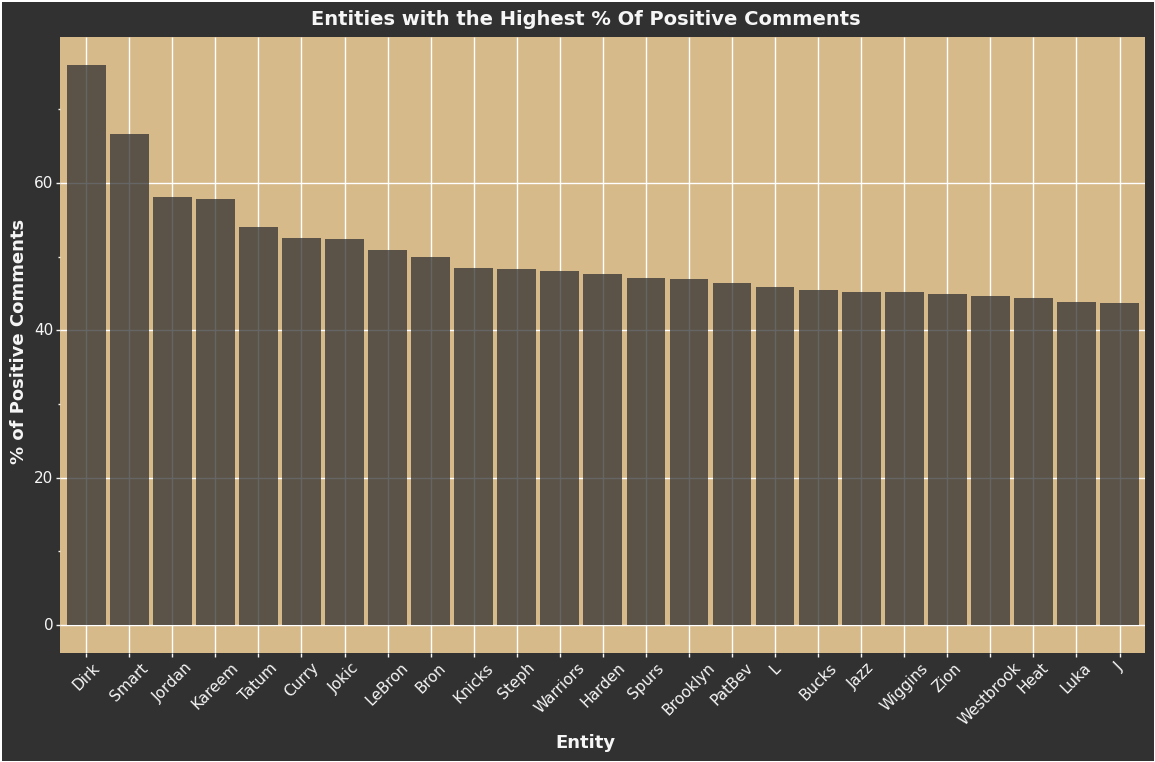

<ggplot: (8741697729690)>

In [128]:
# load the data
entities = LoadCommentSentimentFiles()
combined_entities = CombineEntitesAndSentiments(entities, positive = True)

# selecting the order
named_entity_list = combined_entities['named_entities'][:25].to_list()

p = (ggplot(combined_entities[:25], aes(x = 'named_entities', y = 'fraction')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Entity', y = '% of Positive Comments', title = 'Entities with the Highest % Of Positive Comments') + 
     theme(axis_text_x = (element_text(angle = 45)), plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8)) +
     scale_x_discrete(limits = named_entity_list)
     )
p

# Analyzing the Thread Titles

In [ ]:
from transformers import pipeline

In [ ]:
# selecting the named entity model
ner = pipeline('ner', grouped_entities=True)

# loading the thread data
thread_titles = pd.read_csv('nba_reddit_threads_data.csv')

# applying the model to each thread title
thread_titles['named_entities'] = thread_titles['thread_title'].progress_apply(lambda x: [i['word'] for i in ner(x)])

In [ ]:
# selecting the sentiment analysis classifier
sentiment_classifier = pipeline('sentiment-analysis')

# list to save the sentiments
sentiments = []

# moving through each row and passing it into the classifier, saving the label
for i in range(len(thread_titles)):
    try:
        # putting the title in the classifier
        sentiment = sentiment_classifier(thread_titles['thread_title'][i])[0]['label']
        # saving the sentiment to the list
        sentiments.append(sentiment)
    except:
        # if there is an error, append a blank space
        sentiments.append(' ')
        continue

# save the sentiments to the data frame  
thread_titles['sentiments'] = sentiments


In [ ]:
# expanding the entities to be per row
entities = thread_titles.explode('named_entities')

# Save the entities data frame to a csv
# entities.to_csv('titles_named_entities.csv')

## Graphing The Findings

### The Most Frequent Named Entities in Titles

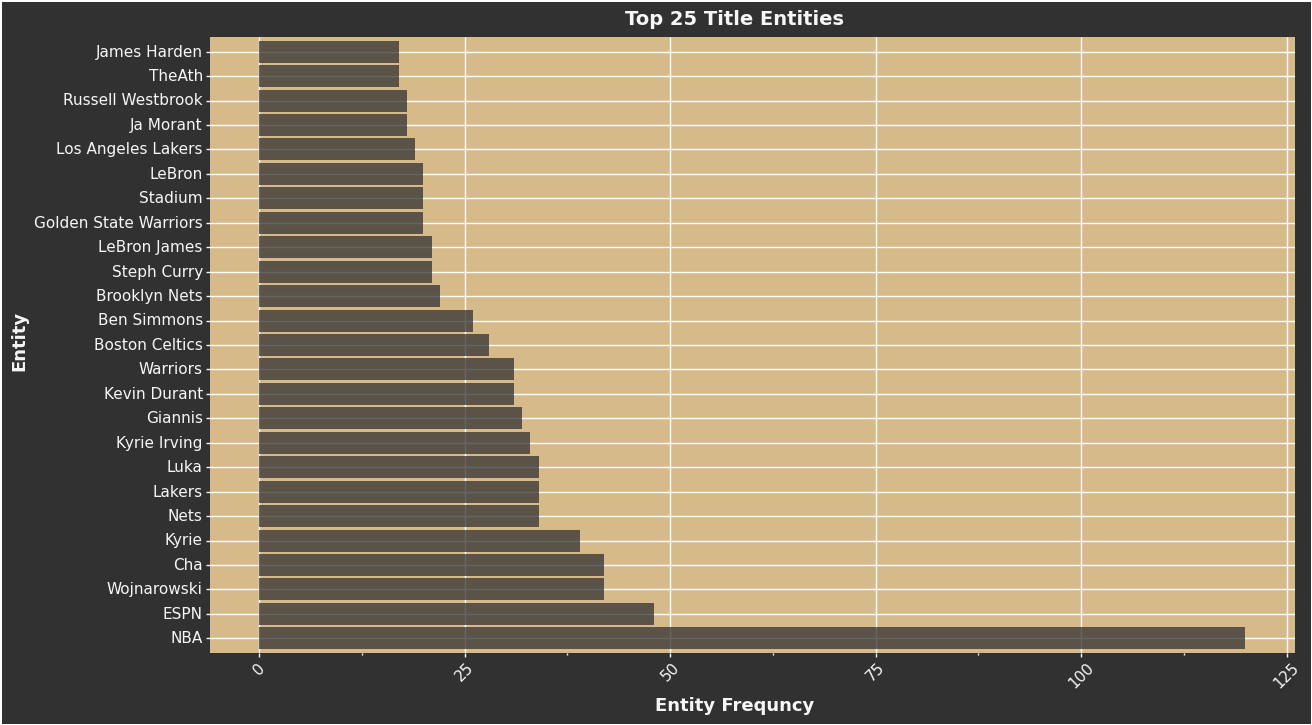

<ggplot: (8741698747164)>

In [129]:
# Load the Data
entities = LoadTitleSentimentFile()
entity_combined, entity_frequency, entity_sentiments = CombineEntitesAndSentiments(entities, positive = False, cutoff = 10, return_sentiment_and_frequency_df = True)

# List to order the data
named_entity_list = entity_frequency['named_entities'][:25].to_list()

p = (ggplot(entity_frequency[:25], aes(x = 'named_entities', y = 'entity_frequency')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Entity', y = 'Entity Frequncy', title = 'Top 25 Title Entities') + 
     theme(axis_text_x = (element_text(angle = 45)), plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8)) +
     scale_x_discrete(limits = named_entity_list) +
     coord_flip()
     )
p

### The Count of Negative & Positive Titles

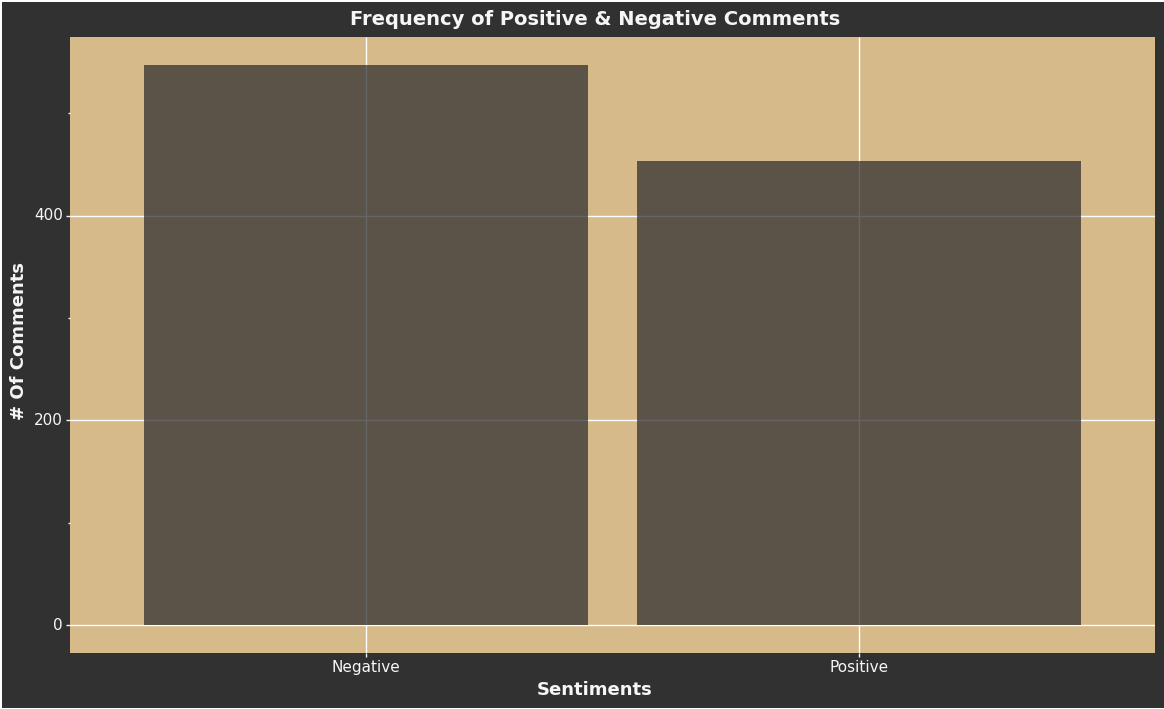

<ggplot: (8741689285843)>

In [130]:
# load data
entities = LoadTitleSentimentFile()

# select for the thread ids and sentiments so there are no duplicates
entities = entities[['thread_ids', 'sentiments']].drop_duplicates() 

# calculate the frequency of the sentiment values
sentiment_frequency = (entities
                  .groupby(by=['sentiments'])
                  .agg({'sentiments': 'count'})
                  .rename(columns={'sentiments': 'sentiment_frequency'})
                  .reset_index()
                 ).sort_values(['sentiment_frequency'], ascending = False)

# taking the labels from all caps to normal
sentiment_frequency['sentiments'][0] = 'Negative'
sentiment_frequency['sentiments'][1] = 'Positive'

p = (ggplot(sentiment_frequency, aes(x = 'sentiments', y = 'sentiment_frequency')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Sentiments', y = '# Of Comments', title = 'Frequency of Positive & Negative Comments') + 
     theme(plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8))
     )
p

## Graphing Negative Titles

### The Named Entities With The Highest Percentage of Negative Titles



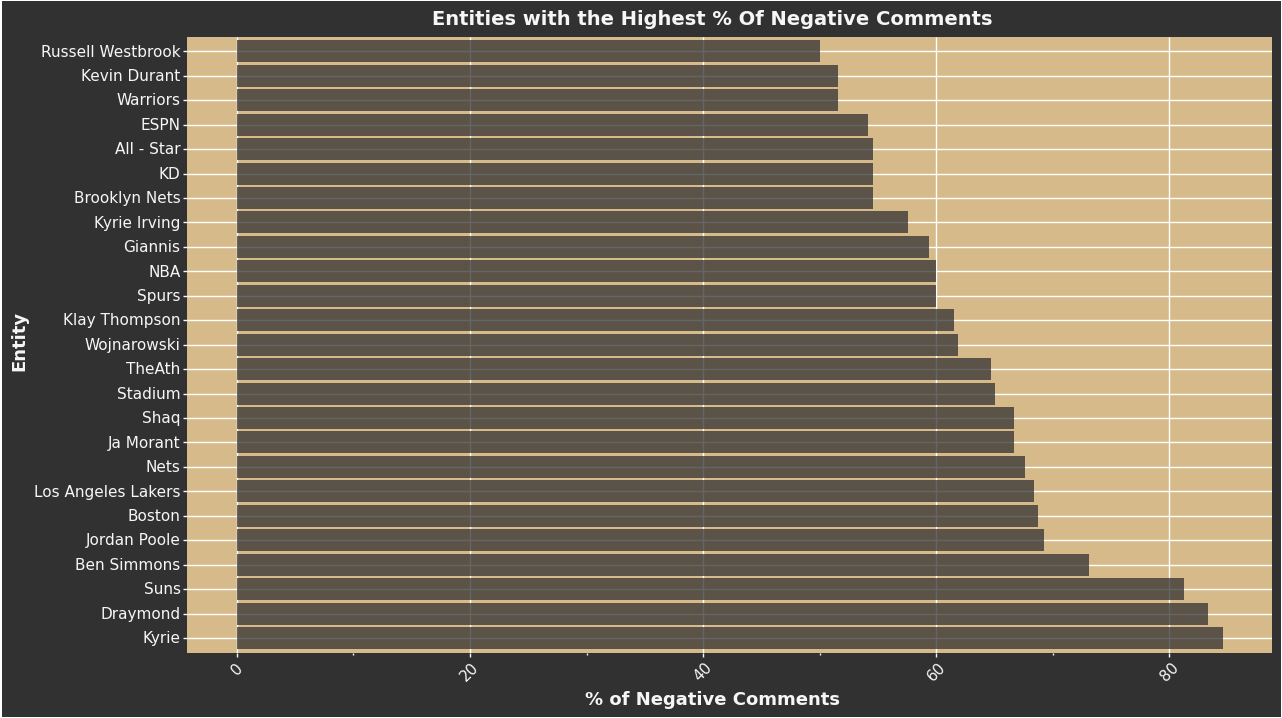

<ggplot: (8741693660905)>

In [131]:
# loading the data
entities = LoadTitleSentimentFile()
entity_combined = CombineEntitesAndSentiments(entities, positive = False, cutoff = 10)

# setting the order
named_entity_list = entity_combined['named_entities'][:25].to_list()

p = (ggplot(entity_combined[:25], aes(x = 'named_entities', y = 'fraction')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Entity', y = '% of Negative Comments', title = 'Entities with the Highest % Of Negative Comments') + 
     theme(axis_text_x = (element_text(angle = 45)), plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8)) +
     scale_x_discrete(limits = named_entity_list) +
     coord_flip()
     )
p

## Graphing Positive Titles

### The Named Entities With The Highest Percentage of Postivie Titles



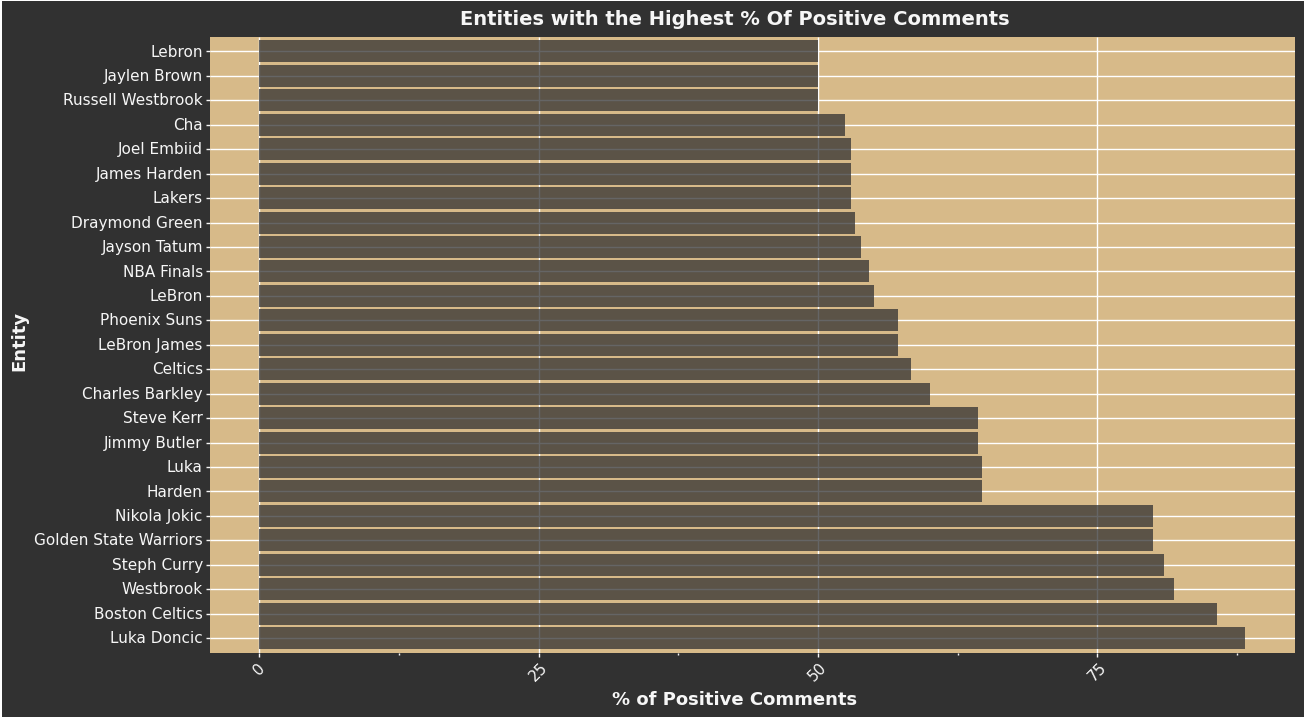

<ggplot: (8741689131486)>

In [132]:
# loading the data
entities = LoadTitleSentimentFile()
entity_combined = CombineEntitesAndSentiments(entities, positive = True, cutoff = 10)

# setting the order
named_entity_list = entity_combined['named_entities'][:25].to_list()

p = (ggplot(entity_combined[:25], aes(x = 'named_entities', y = 'fraction')) + 
     geom_bar(stat = 'identity',  fill = '#313131', alpha = .75) + 
     labs(x = 'Entity', y = '% of Positive Comments', title = 'Entities with the Highest % Of Positive Comments') + 
     theme(axis_text_x = (element_text(angle = 45)), plot_background = element_rect(fill = '#313131'), panel_background = element_rect(fill = '#D7BA89'), 
        plot_title = element_text(color = '#f6f6f6', face = 'bold', size = 14), axis_title = element_text(color = '#f6f6f6', face = 'bold', size = 13), 
        axis_text = element_text(color = '#f6f6f6', size = 11),
        axis_ticks = element_line(color = '#f6f6f6'),
        panel_grid_minor = element_line(linetype = 'dashed', linewidth = 0.01)) + 
     theme(figure_size = (14,8)) +
     scale_x_discrete(limits = named_entity_list) +
     coord_flip()
     )
p